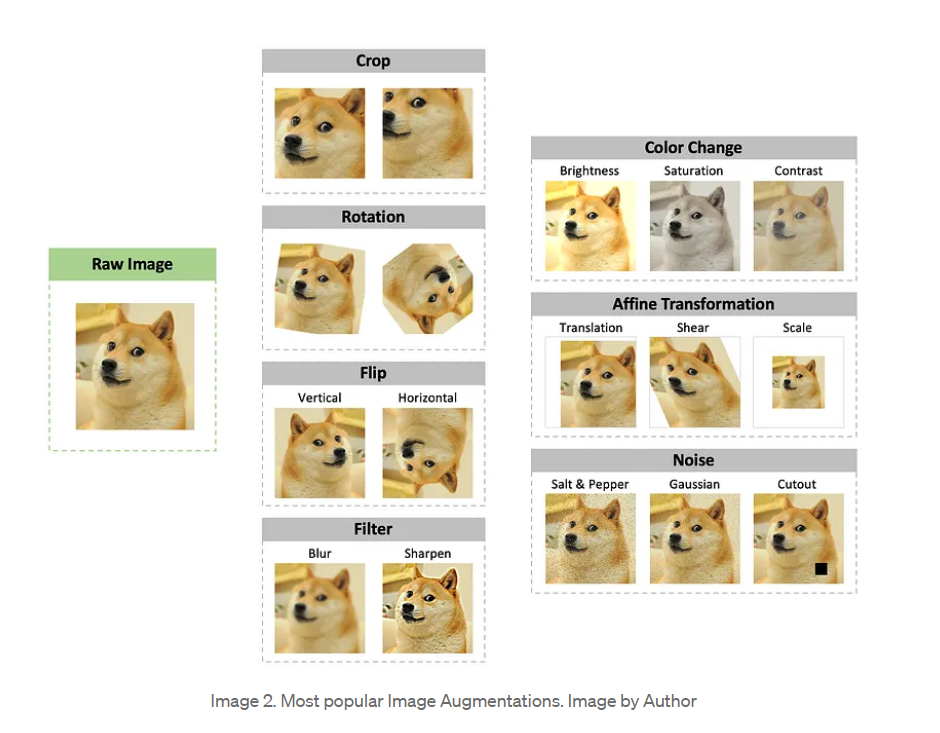

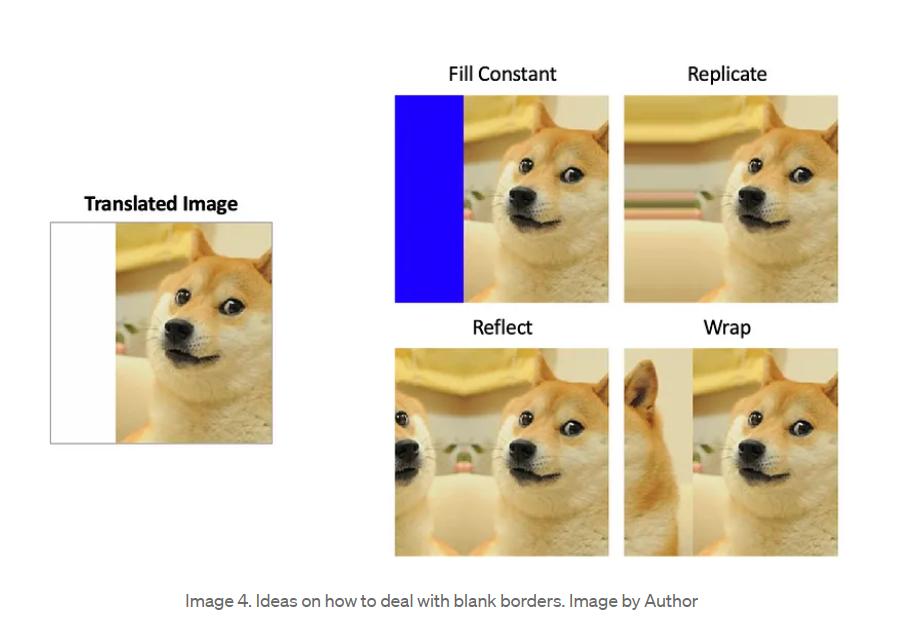

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# Data Augmentation Pipeline
data_augmentation = Sequential([
    # Crop
    layers.RandomCrop(height=180, width=180),
    # When to use: Use when you want to focus on different parts of an image, helping the model learn from various perspectives.

    # Rotation
    layers.RandomRotation(factor=0.2),
    # When to use: Useful when objects in your images can appear at different angles, e.g., aerial images, or when rotation invariance is important.

    # Flip
    layers.RandomFlip(mode='horizontal_and_vertical'),
    # When to use: Commonly used when objects might appear mirrored or in different orientations. Horizontal flip is especially common for images like animals or landscapes.

    # Brightness Adjustment
    layers.RandomBrightness(factor=0.2),
    # When to use: Use when your images are taken under varying lighting conditions, helping the model learn to generalize across different brightness levels.

    # Contrast Adjustment
    layers.RandomContrast(factor=0.2),
    # When to use: Useful when the contrast in images can vary, such as in outdoor photography where lighting conditions might change.

    # Zoom
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    # When to use: Use when objects can appear at different scales, helping the model handle both close-up and distant views.

    # Translation
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='reflect') # Other fill modes: 'constant', 'wrap', 'replicate',
    # When to use: Apply when objects in the images may not be centered, to help the model learn positional invariance.

    # Affine Transformations (Shear)
    layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomRotation(0.2), # Similar to Affine
    layers.experimental.preprocessing.RandomZoom(0.1, 0.1), # Similar to Affine
    # When to use: Affine transformations can simulate different perspectives of an object by shearing, rotating, and scaling images. Use when your model needs to be robust to slight geometric distortions.

    # Noise Addition
    layers.GaussianNoise(stddev=0.1),
    # When to use: Useful in scenarios where the input data might have some noise, like in medical images or low-quality photographs.

    # Salt and Pepper Noise (Custom Layer)
    layers.Lambda(lambda x: tf.image.random_jpeg_quality(x, 60, 100)),
    # When to use: Use salt and pepper noise to simulate images that may have been corrupted with this kind of noise, such as old scanned photos.

    # Cutout (Custom Layer)
    layers.Lambda(lambda x: tf.image.random_cutout(x, size=(50, 50))),
    # When to use: Use Cutout to randomly mask out sections of the image, encouraging the model to focus on global rather than local features.

    # Padding (Custom)
    layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='reflect'),
    # When to use: Padding can help when translating images to ensure the content is preserved and gaps are filled meaningfully.
])

# Example Dataset Loading and Augmentation Application

# Loading an example dataset
(train_ds, val_ds), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

# Normalization Function
def norm_images(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

# Apply Data Augmentation and Normalization
train_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_augmented_norm = train_augmented.map(norm_images)
val_norm = val_ds.map(norm_images)

# Model Definition
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the Model
history = model.fit(
    train_augmented_norm,
    validation_data=val_norm,
    epochs=20,
    callbacks=[early_stopping]
)

# Model Evaluation
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
